In [2]:
import pandas as pd
import os
import gc


# --- Define File Paths ---
PARQUET_DATA_DIR = '../data_parquet/'
OPTIMIZED_TRAIN_PATH = os.path.join(PARQUET_DATA_DIR, 'train_optimized.parquet')
SAMPLE_PATH = os.path.join(PARQUET_DATA_DIR, 'train_sample.parquet')
CSV_DATA_DIR = '../data/'
LABELS_PATH = os.path.join(CSV_DATA_DIR, 'train_labels.csv')

# --- Create the Sample ---
if not os.path.exists(SAMPLE_PATH):
    print(f"Loading {OPTIMIZED_TRAIN_PATH} to create a sample...")
    
    # Load the full data
    train_df = pd.read_parquet(OPTIMIZED_TRAIN_PATH)
    
    # Get all unique customer IDs from the full data
    all_customer_ids = train_df['customer_ID'].unique()
    
    # --- Create a 10% Sample ---
    # We'll sample 10% of the unique customers
    sample_size = int(len(all_customer_ids) * 0.10) 
    
    # Get the labels to ensure our sample has the same
    # proportion of 0s and 1s as the full dataset (stratified sample)
    train_labels = pd.read_csv(LABELS_PATH)
    
    # Get a 10% stratified sample of customer IDs
    sample_customer_ids = train_labels.groupby('target', group_keys=False)\
                                      .apply(lambda x: x.sample(frac=0.10, random_state=42))['customer_ID']

    print(f"Original customer count: {len(all_customer_ids)}")
    print(f"New sample customer count: {len(sample_customer_ids)}")

    # Filter the main DataFrame to only include customers in our sample
    print("Filtering main DataFrame...")
    train_sample_df = train_df[train_df['customer_ID'].isin(sample_customer_ids)]
    
    # Save the new sample file
    print(f"Saving sample to {SAMPLE_PATH}...")
    train_sample_df.to_parquet(SAMPLE_PATH)
    
    print("Sample created successfully.")
    print(f"Sample shape: {train_sample_df.shape}")
    
    # Clean up memory
    del train_df, train_sample_df
    gc.collect()
    
else:
    print(f"{SAMPLE_PATH} already exists. Loading it.")
    train_sample_df = pd.read_parquet(SAMPLE_PATH)
    print(f"Sample loaded. Shape: {train_sample_df.shape}")

../data_parquet/train_sample.parquet already exists. Loading it.
Sample loaded. Shape: (553406, 190)


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

# --- Define Paths ---
PARQUET_DATA_DIR = '../data_parquet/'
CSV_DATA_DIR = '../data/'
SAMPLE_PATH = os.path.join(PARQUET_DATA_DIR, 'train_sample.parquet')
LABELS_PATH = os.path.join(CSV_DATA_DIR, 'train_labels.csv')

# --- Load Data ---
print("Loading sample data...")
train_sample_df = pd.read_parquet(SAMPLE_PATH)
train_labels = pd.read_csv(LABELS_PATH)

# --- Merge ---
print("Merging sample with labels...")
train_sample_merged = train_sample_df.merge(train_labels, on='customer_ID', how='left')

print(f"Sample ready. Shape: {train_sample_merged.shape}")
print(train_sample_merged.head())

Loading sample data...
Merging sample with labels...
Sample ready. Shape: (553406, 191)
                                         customer_ID         S_2       P_2  \
0  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2017-03-11  0.876615   
1  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2017-04-11  0.887385   
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2017-05-12  0.884522   
3  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2017-06-10  0.852514   
4  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  2017-07-12  0.891656   

       D_39       B_1       B_2       R_1  S_3      D_41       B_3  ...  \
0  0.001469  0.001472  0.810796  0.005955  NaN  0.008401  0.004826  ...   
1  0.004229  0.002125  0.819078  0.004521  NaN  0.008008  0.007282  ...   
2  0.003399  0.003495  0.818569  0.007541  NaN  0.007537  0.000859  ...   
3  0.006877  0.007627  0.819987  0.009290  NaN  0.003959  0.007532  ...   
4  0.000802  0.009997  0.811041  0.003540  NaN  0.009034  0.000626  


Sample Shape: (553406, 191)

Target Distribution (Normalized):
target
0    0.750666
1    0.249334
Name: proportion, dtype: float64

Missing Values (Top 10 in Sample):
D_87     552946
D_88     552792
D_108    550533
D_111    550133
D_110    550133
B_39     549922
D_73     547647
B_42     546634
D_135    534179
D_136    534179
dtype: int64

Plotting distribution of raw P_2 feature...


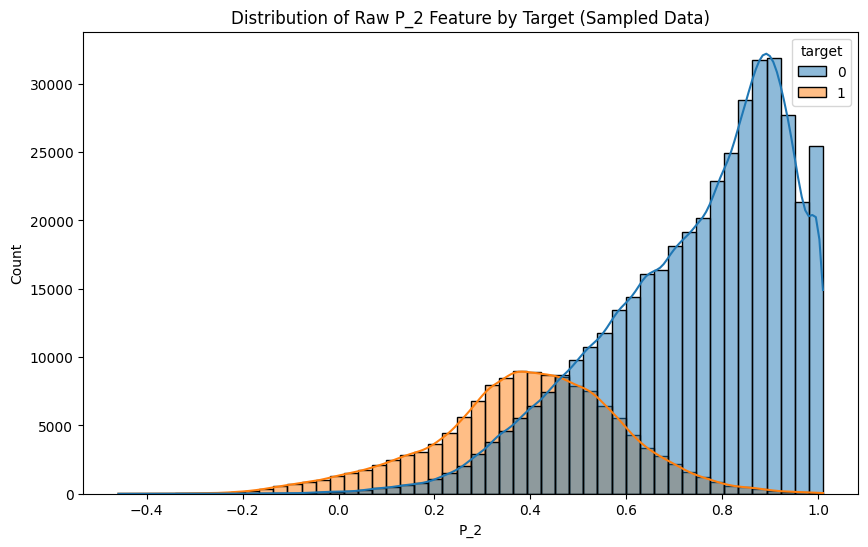

In [4]:
# --- Basic Exploration ---
print(f"\nSample Shape: {train_sample_merged.shape}")

print("\nTarget Distribution (Normalized):")
print(train_sample_merged['target'].value_counts(normalize=True))

print("\nMissing Values (Top 10 in Sample):")
print(train_sample_merged.isna().sum().sort_values(ascending=False).head(10))

# --- Visualize a Key Raw Feature ---
print("\nPlotting distribution of raw P_2 feature...")
plt.figure(figsize=(10, 6))
sns.histplot(data=train_sample_merged, x='P_2', hue='target', kde=True, bins=50)
plt.title('Distribution of Raw P_2 Feature by Target (Sampled Data)')
plt.show()

In [5]:
# --- Feature Engineering Function (Example - Adapt as needed) ---
def create_features_sample(df):
    print("Creating aggregate features from sample...")
    # Define numerical and categorical features (use ALL columns initially for baseline)
    cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    numerical_cols = [col for col in df.columns if col not in cat_features + ['customer_ID', 'S_2', 'target']]

    # Aggregate numerical features
    num_aggregates = df.groupby('customer_ID')[numerical_cols].agg(['mean', 'std', 'min', 'max', 'last'])
    num_aggregates.columns = ['_'.join(col) for col in num_aggregates.columns]

    # Aggregate categorical features
    cat_aggregates = df.groupby('customer_ID')[cat_features].agg(['last', 'nunique'])
    cat_aggregates.columns = ['_'.join(col) for col in cat_aggregates.columns]

    # Combine
    X_agg = pd.concat([num_aggregates, cat_aggregates], axis=1)
    print(f"Aggregated features created. Shape: {X_agg.shape}")
    return X_agg

# --- Apply Feature Engineering ---
X_sample_agg = create_features_sample(train_sample_merged)

# --- Merge back with labels ---
# Need customer_ID and target from labels for imputation comparison
train_labels_sample = train_labels[train_labels['customer_ID'].isin(X_sample_agg.index)]
X_sample_agg_merged = X_sample_agg.merge(train_labels_sample, on='customer_ID', how='left')

print("\nAggregated sample features merged with labels:")
print(X_sample_agg_merged.head())

Creating aggregate features from sample...
Aggregated features created. Shape: (45891, 907)

Aggregated sample features merged with labels:
                                         customer_ID  P_2_mean   P_2_std  \
0  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  0.878454  0.028911   
1  0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  1.005816  0.003309   
2  0004837f0c785928a29a6f83f70f4a1c54caec483a773f...  0.665203  0.028379   
3  0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...  0.986126  0.023979   
4  00062483fb33d6129dd4ee7e5a12f751d2e7010ac0df01...  0.637514  0.056002   

    P_2_min   P_2_max  P_2_last  D_39_mean  D_39_std  D_39_min  D_39_max  ...  \
0  0.797670  0.904482  0.880875   0.004181  0.002758  0.000802  0.009704  ...   
1  1.000488  1.009762  1.009762   0.353440  0.215033  0.000811  0.560899  ...   
2  0.628740  0.712943  0.642295   0.450042  0.208705  0.005359  0.685210  ...   
3  0.928659  1.007868  0.988091   0.334321  0.187328  0.003688  0.618437  ...  

In [7]:
# Continue in your Combined_EDA.ipynb notebook

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

# Import the Amex Metric function (Make sure amex_metric.py is accessible)
try:
    from amex_metric import amex_metric
except ImportError:
    print("Warning: amex_metric.py not found. Amex Metric calculation will be skipped.")
    amex_metric = None # Define as None if import fails

# --- 1. Prepare Data for Imputation ---
print("Preparing data for imputation experiment...")
# Ensure X_sample_agg_merged exists from the previous cell
if 'X_sample_agg_merged' not in locals():
    print("Error: X_sample_agg_merged not found. Please run the previous cell first.")
else:
    # Separate features (X) and target (y) from the merged aggregated sample
    X_agg_base = X_sample_agg_merged.drop(columns=['target']).copy() # Use .copy()
    y_sample = X_sample_agg_merged['target'].copy()

    print("\nOne-Hot Encoding aggregated categorical '_last' features...")

    # Identify the original categorical features from the competition description/EDA
    original_cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

    # Find the columns in X_agg_base that end with '_last' and correspond to the originals
    cols_to_encode = [f'{col}_last' for col in original_cat_features if f'{col}_last' in X_agg_base.columns and X_agg_base[f'{col}_last'].dtype == 'object']

    if cols_to_encode:
        print(f"Encoding columns: {cols_to_encode}")
        # Perform One-Hot Encoding
        X_agg_base = pd.get_dummies(X_agg_base, columns=cols_to_encode, dummy_na=False) 
        print(f"Shape after encoding: {X_agg_base.shape}")
    else:
        print("No object type '_last' categorical columns found to encode.")

    # --- 2. Strategy 1: Fill with Zero ---
    print("\nCreating dataset: Fill with Zero")
    X_zero_imputed = X_agg_base.fillna(0).copy() 

    # --- 3. Strategy 2: Fill with Median ---
    print("Creating dataset: Fill with Median")
    X_median_imputed = X_agg_base.copy() 

    # Calculate medians only from numeric columns
    print("Calculating medians...")
    numeric_cols_agg = X_median_imputed.select_dtypes(include=np.number).columns
    medians = X_median_imputed[numeric_cols_agg].median()

    # Fill numeric NaNs with their respective medians
    X_median_imputed[numeric_cols_agg] = X_median_imputed[numeric_cols_agg].fillna(medians)

    # Handle any remaining NaNs 
    if X_median_imputed.isnull().sum().sum() > 0:
        print(f"Filling {X_median_imputed.isnull().sum().sum()} remaining NaNs with -1 (check if these are expected)...")
        X_median_imputed = X_median_imputed.fillna(-1) 

    # --- 4. Cross-Validation Function ---
    def run_cv(X, y, strategy_name):
        print(f"\nRunning 5-Fold CV for strategy: {strategy_name}")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = []
        amex_scores = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = lgb.LGBMClassifier(random_state=42, n_jobs=-1) 
            # Drop customer_ID just for training
            model.fit(X_train.drop(columns=['customer_ID']), y_train)

            # ----- THIS IS THE FIX -----
            # Drop customer_ID just for predicting
            preds = model.predict_proba(X_val.drop(columns=['customer_ID']))[:, 1]
            # ---------------------------

            auc = roc_auc_score(y_val, preds)
            auc_scores.append(auc)

            amex_score_val = np.nan
            if amex_metric:
                try:
                    y_val_df = y_val.to_frame(name='target')
                    preds_df = pd.DataFrame({'prediction': preds}, index=y_val.index)
                    amex_score_val = amex_metric(y_val_df, preds_df)
                    amex_scores.append(amex_score_val)
                except Exception as e:
                    print(f"  Fold {fold+1}: Error calculating Amex metric: {e}")
                    amex_scores.append(np.nan)

            print(f"  Fold {fold+1} AUC: {auc:.4f}, Amex Metric: {amex_score_val:.4f}")

            del X_train, X_val, y_train, y_val, model, preds
            gc.collect()

        mean_auc = np.mean(auc_scores)
        std_auc = np.std(auc_scores)
        mean_amex = np.nanmean(amex_scores) if amex_scores else np.nan
        std_amex = np.nanstd(amex_scores) if amex_scores else np.nan

        print(f"\n{strategy_name} - Average AUC: {mean_auc:.4f} +/- {std_auc:.4f}")
        if amex_metric and not np.isnan(mean_amex):
             print(f"{strategy_name} - Average Amex Metric: {mean_amex:.4f} +/- {std_amex:.4f}")
        return mean_auc, mean_amex 

    # --- 5. Run Experiments ---
    print("\nStarting imputation experiments...")
    auc_zero, amex_zero = run_cv(X_zero_imputed, y_sample, "Zero Imputation")
    auc_median, amex_median = run_cv(X_median_imputed, y_sample, "Median Imputation")

    # --- 6. Decide Best Strategy & Prepare Output ---
    if auc_median > auc_zero: 
        print("\nMedian imputation performed slightly better based on AUC.")
        X_baseline_imputed = X_median_imputed.copy()
        best_imputation_strategy = 'Median'
    else:
        print("\nZero imputation performed better or equally based on AUC.")
        X_baseline_imputed = X_zero_imputed.copy()
        best_imputation_strategy = 'Zero'

    print(f"Selected '{best_imputation_strategy}' imputation for the baseline dataset.")

    # Clean up intermediate dataframes
    del X_zero_imputed, X_median_imputed, X_agg_base
    gc.collect()

    print(f"\nBaseline imputed dataset 'X_baseline_imputed' ready. Shape: {X_baseline_imputed.shape}")

Preparing data for imputation experiment...

One-Hot Encoding aggregated categorical '_last' features...
Encoding columns: ['D_63_last', 'D_64_last']
Shape after encoding: (45891, 916)

Creating dataset: Fill with Zero
Creating dataset: Fill with Median
Calculating medians...

Starting imputation experiments...

Running 5-Fold CV for strategy: Zero Imputation
[LightGBM] [Info] Number of positive: 9506, number of negative: 27206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 219405
[LightGBM] [Info] Number of data points in the train set: 36712, number of used features: 913
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258934 -> initscore=-1.051514
[LightGBM] [Info] Start training from score -1.051514
  Fold 1 AUC: 0.9561, Amex Metric: 0.7635
[LightGBM] [Info] Number of positive: 9507, number of negative: 27206
[LightGBM] [Info] Auto-choosin


Analyzing missing values in AGGREGATED features (before imputation)...
Number of aggregated features with missing values: 582
Top 15 Aggregated Features with Missing Values:
   Aggregated_Feature  MissingRatio
0            D_87_std      0.998802
1            D_87_max      0.997973
2           D_87_last      0.997973
3           D_87_mean      0.997973
4            D_87_min      0.997973
5            D_88_std      0.995555
6           D_88_mean      0.994705
7           D_88_last      0.994705
8            D_88_max      0.994705
9            D_88_min      0.994705
10          D_110_std      0.991371
11          D_111_std      0.991371
12           B_39_std      0.991349
13          D_110_min      0.991044
14          D_110_max      0.991044


C:\Users\user\AppData\Local\Temp\ipykernel_46044\344443369.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MissingRatio', y='Aggregated_Feature', data=missing_agg_df.head(25), palette='magma')


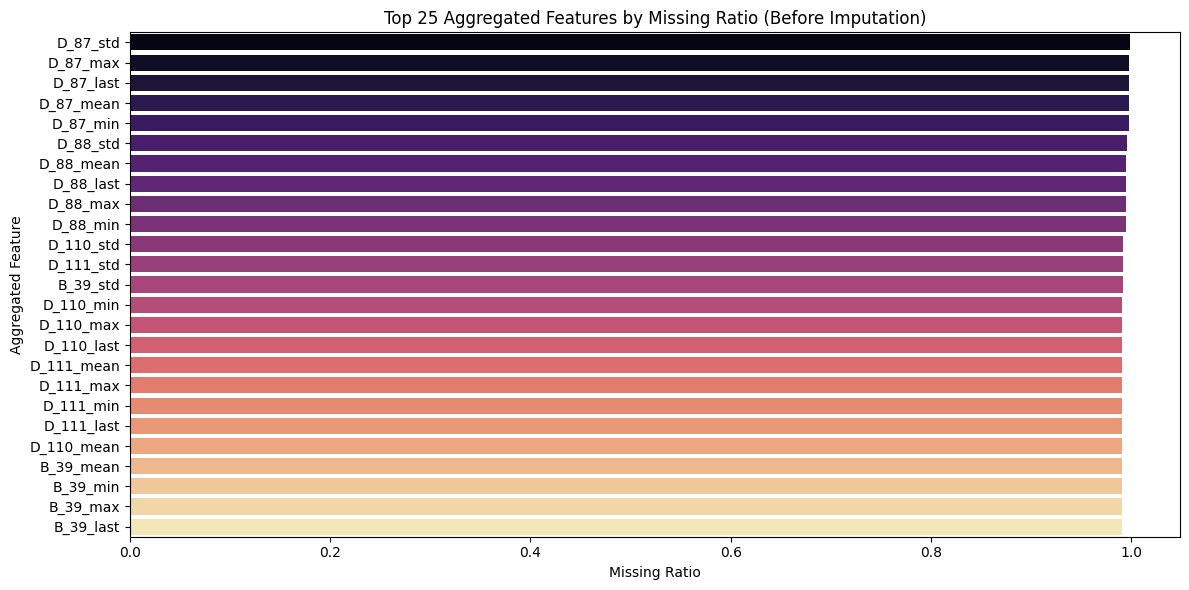

214

In [8]:
# Add this after determining X_baseline_imputed

print("\nAnalyzing missing values in AGGREGATED features (before imputation)...")
# Recalculate X_agg_base if it was deleted
X_agg_base = X_sample_agg_merged.drop(columns=['customer_ID', 'target']).copy()

missing_agg = (X_agg_base.isnull().sum() / len(X_agg_base)).sort_values(ascending=False)
missing_agg_df = missing_agg[missing_agg > 0].reset_index() # Only show features with missing values
missing_agg_df.columns = ['Aggregated_Feature', 'MissingRatio']

print(f"Number of aggregated features with missing values: {len(missing_agg_df)}")
print("Top 15 Aggregated Features with Missing Values:")
print(missing_agg_df.head(15))

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='MissingRatio', y='Aggregated_Feature', data=missing_agg_df.head(25), palette='magma')
plt.title('Top 25 Aggregated Features by Missing Ratio (Before Imputation)')
plt.xlabel('Missing Ratio')
plt.ylabel('Aggregated Feature')
plt.tight_layout()
plt.show()

del X_agg_base # Clean up
gc.collect()


Visualizing key AGGREGATED categorical features by target...

--- Text Data for Plot: D_63_nunique ---
|   target |   D_63_nunique |   proportion |
|---------:|---------------:|-------------:|
|        0 |              1 |  0.933075    |
|        0 |              2 |  0.0601035   |
|        0 |              3 |  0.00623383  |
|        0 |              4 |  0.000499882 |
|        0 |              5 |  8.82145e-05 |
|        1 |              1 |  0.932845    |
|        1 |              2 |  0.0621055   |
|        1 |              3 |  0.00488092  |
|        1 |              4 |  8.41538e-05 |
|        1 |              5 |  8.41538e-05 |
--------------------------------------------------

--- Text Data for Plot: D_64_nunique ---
|   target |   D_64_nunique |   proportion |
|---------:|---------------:|-------------:|
|        0 |              1 |  0.770142    |
|        0 |              2 |  0.201805    |
|        0 |              3 |  0.0174077   |
|        0 |              0 |  0.01043

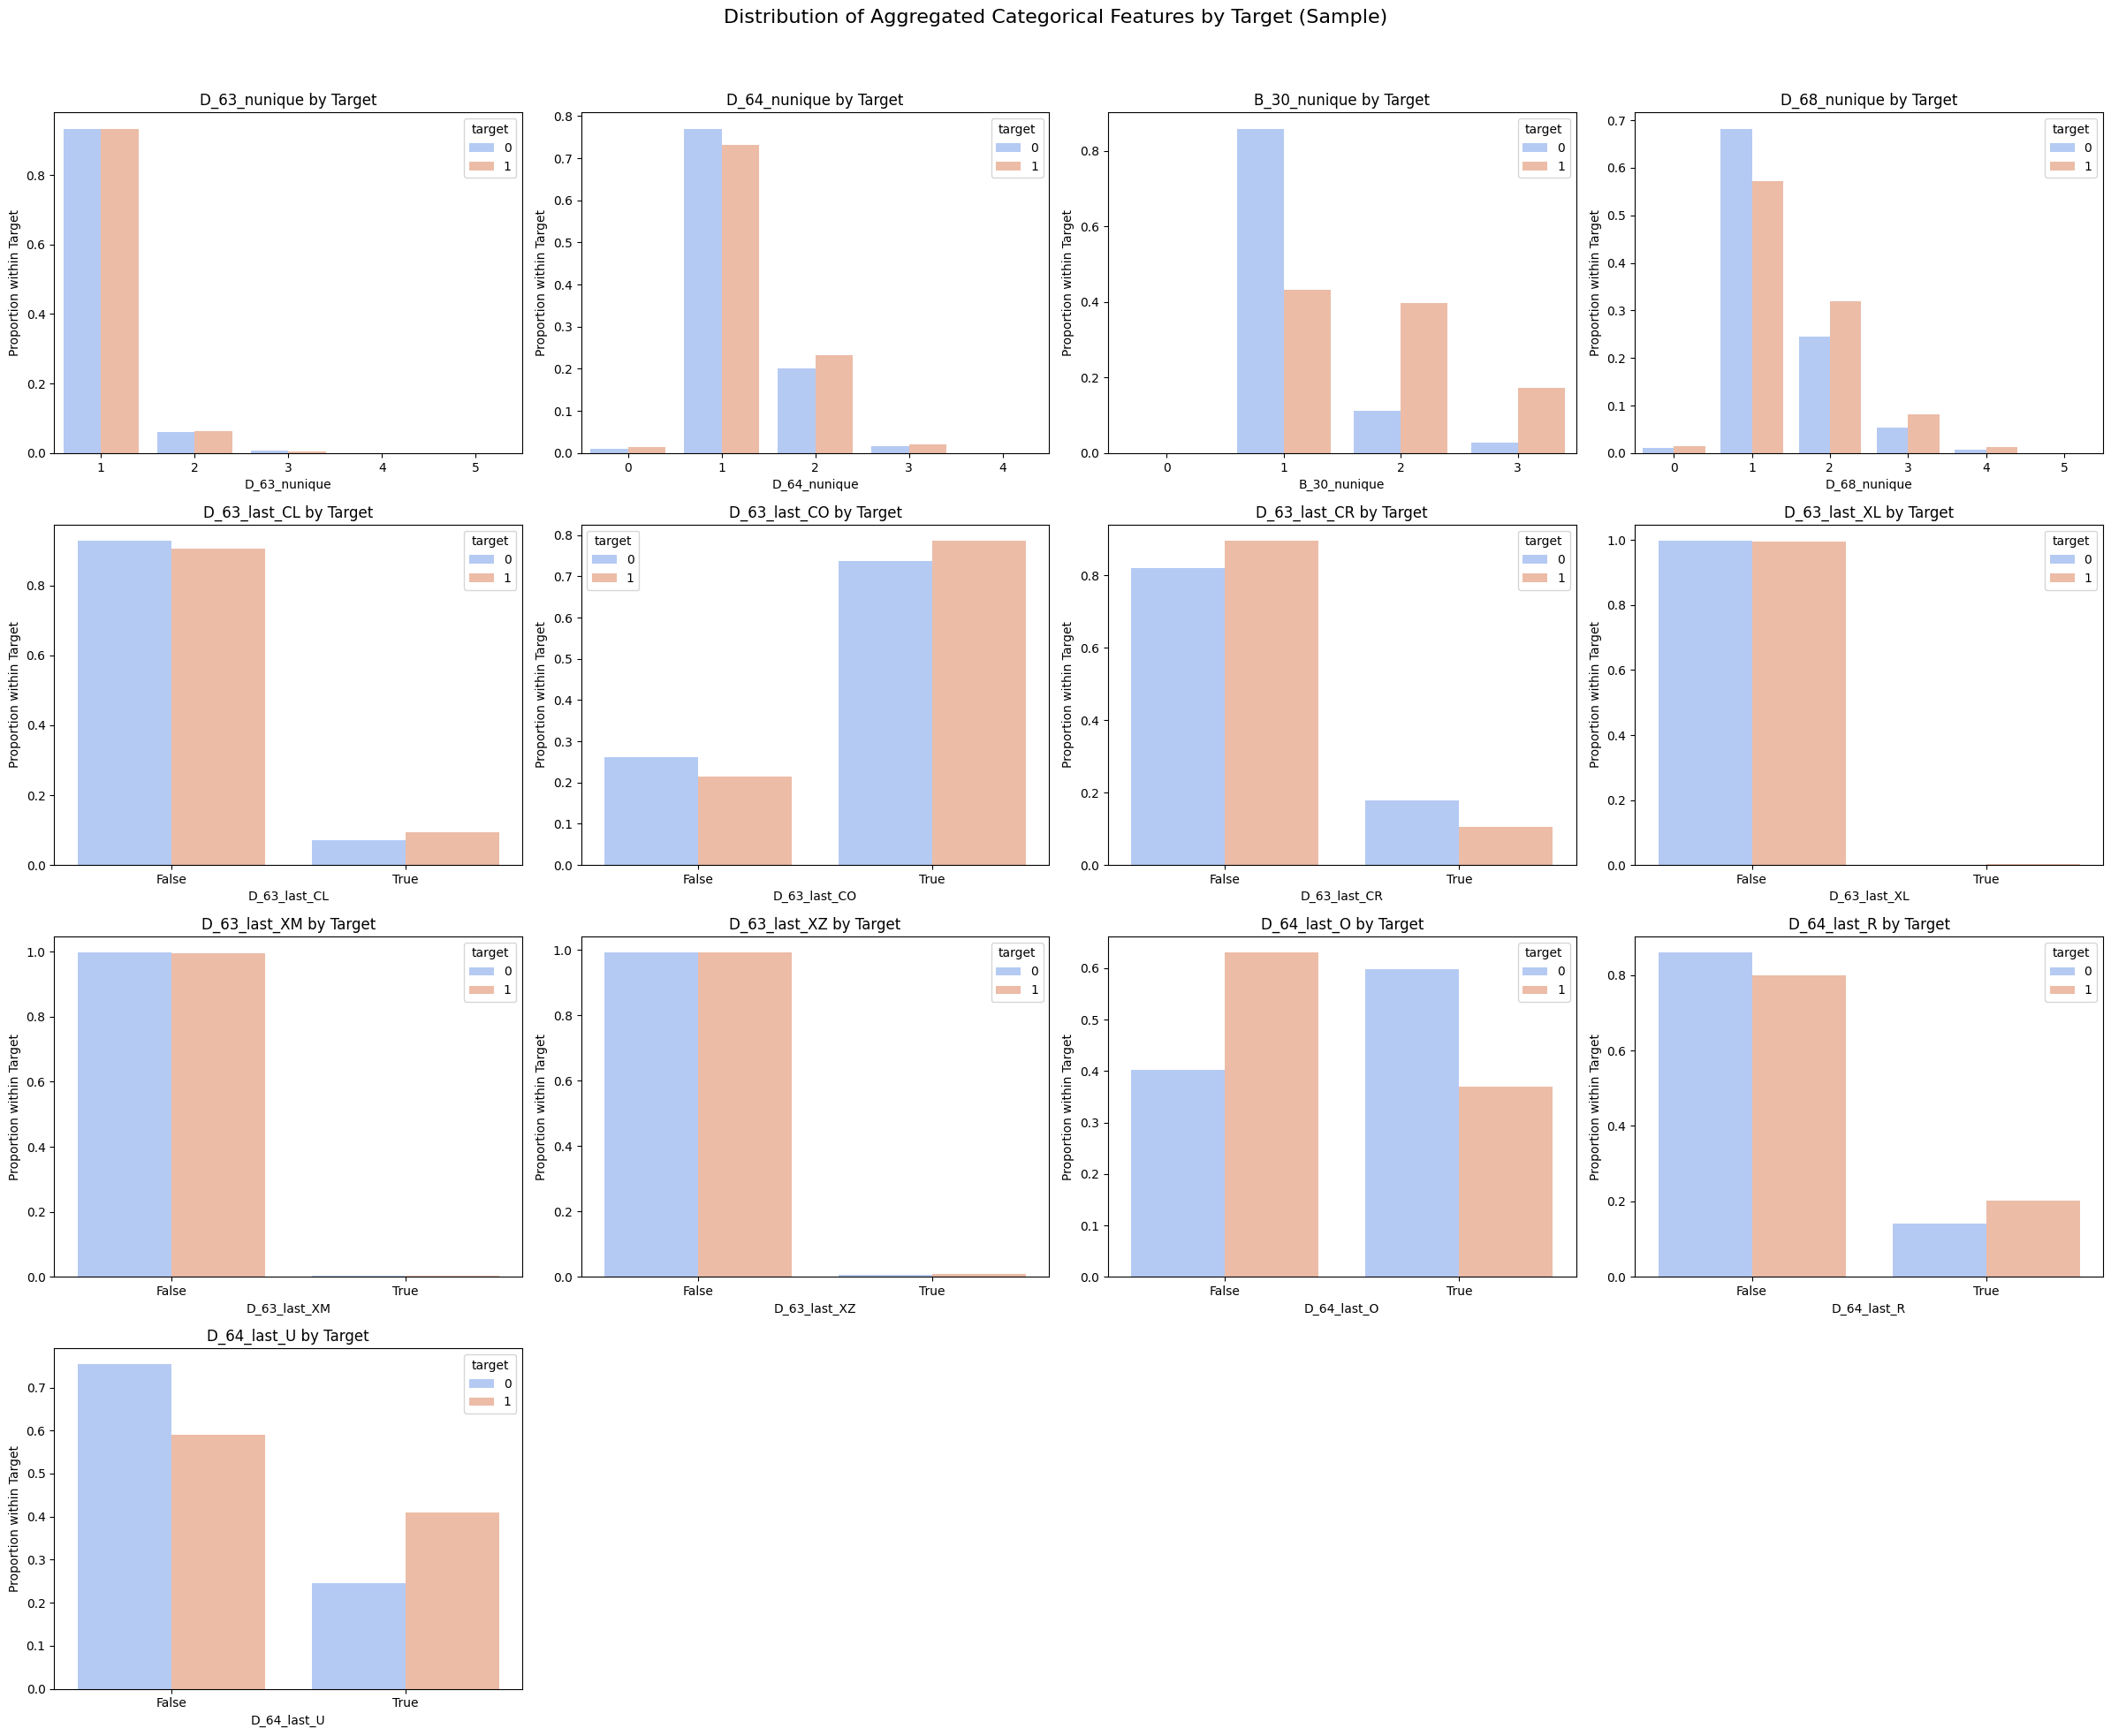

In [9]:
# Continue in your Combined_EDA.ipynb notebook

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc

# Ensure X_baseline_imputed and y_sample exist from the previous steps
if 'X_baseline_imputed' not in locals() or 'y_sample' not in locals():
    print("Error: Required DataFrames (X_baseline_imputed, y_sample) not found.")
else:
    print("\nVisualizing key AGGREGATED categorical features by target...")

    # Identify some key aggregated categorical columns to investigate
    # These examples include _nunique and some results from one-hot encoding _last
    # Adjust the list based on columns present in YOUR X_baseline_imputed
    agg_cat_features_to_plot = [
        'D_63_nunique', 'D_64_nunique', 'B_30_nunique', 'D_68_nunique',
        'D_63_last_CL', 'D_63_last_CO', 'D_63_last_CR', 'D_63_last_XL', 'D_63_last_XM', 'D_63_last_XZ',# Examples from D_63_last OHE
        'D_64_last_O', 'D_64_last_R', 'D_64_last_U', #'D_64_last_-1', # Example placeholder if used
        'B_30_last_0.0', 'B_30_last_1.0', 'B_30_last_2.0', # Example from B_30_last OHE
        'D_68_last_0.0', 'D_68_last_1.0', 'D_68_last_2.0','D_68_last_3.0','D_68_last_4.0','D_68_last_5.0','D_68_last_6.0' # Example from D_68_last OHE
    ]

    # Filter list to only include columns actually present in the DataFrame
    agg_cat_features_to_plot = [col for col in agg_cat_features_to_plot if col in X_baseline_imputed.columns]

    if not agg_cat_features_to_plot:
        print("Warning: None of the example categorical features found in the DataFrame. Skipping plots.")
    else:
        # Create a temporary DataFrame for plotting
        temp_plot_df = pd.concat([X_baseline_imputed[agg_cat_features_to_plot], y_sample], axis=1)

        num_plots = len(agg_cat_features_to_plot)
        num_cols = 4 # Adjust number of columns for layout
        num_rows = (num_plots + num_cols - 1) // num_cols

        plt.figure(figsize=(6 * num_cols, 5 * num_rows))

        for i, feature in enumerate(agg_cat_features_to_plot):
            plt.subplot(num_rows, num_cols, i + 1)
            # Use countplot for binary (OHE) or low-cardinality _nunique features
            # Use histplot if _nunique has many distinct values
            if temp_plot_df[feature].nunique() <= 10: # Adjust threshold if needed
                 # Calculate proportions for countplot
                 prop_df = temp_plot_df.groupby('target')[feature].value_counts(normalize=True).rename('proportion').reset_index()
                 sns.barplot(data=prop_df, x=feature, y='proportion', hue='target', palette='coolwarm')
                 plt.ylabel('Proportion within Target') # More informative y-label
            else:
                 # Use stat='proportion' for histplot to show relative frequencies
                 sns.histplot(data=temp_plot_df, x=feature, hue='target', kde=False, bins=20, palette='coolwarm', stat='proportion', common_norm=False)
                 plt.ylabel('Proportion within Target')

            plt.title(f'{feature} by Target')
            # --- ADD TEXT OUTPUT ---
            print(f"\n--- Text Data for Plot: {feature} ---")
            print(prop_df.to_markdown(index=False))
            print("-" * 50)
            # --- END TEXT OUTPUT ---


        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
        plt.suptitle('Distribution of Aggregated Categorical Features by Target (Sample)', fontsize=16, y=1.01)
        plt.show()

        del temp_plot_df # Clean up
        gc.collect()

In [10]:
# Continue in your Combined_EDA.ipynb notebook

from scipy.stats import ks_2samp
import pandas as pd
import gc

# Ensure X_baseline_imputed and y_sample exist
if 'X_baseline_imputed' not in locals() or 'y_sample' not in locals():
    print("Error: Required DataFrames (X_baseline_imputed, y_sample) not found.")
else:
    print("\nCalculating KS statistic for final AGGREGATED & IMPUTED features...")

    ks_results_agg = []
    # Temporarily combine features and target for easy filtering
    temp_ks_df = pd.concat([X_baseline_imputed, y_sample], axis=1)

    features_to_test = X_baseline_imputed.columns # Test all features

    for f in features_to_test:
        # Separate data for target=0 and target=1
        group0 = temp_ks_df.loc[temp_ks_df['target'] == 0, f].dropna() # Should be no NaNs after imputation
        group1 = temp_ks_df.loc[temp_ks_df['target'] == 1, f].dropna()

        # Ensure both groups have data to compare
        if len(group0) > 0 and len(group1) > 0:
            ks_stat, p_value = ks_2samp(group0, group1)
            ks_results_agg.append((f, ks_stat, p_value))
        else:
            # This case shouldn't happen often after imputation, but handles edge cases
            ks_results_agg.append((f, 0.0, 1.0))


    ks_agg_df = pd.DataFrame(ks_results_agg, columns=['Aggregated_Feature', 'KS_Statistic', 'p_value'])
    ks_agg_df = ks_agg_df.sort_values('KS_Statistic', ascending=False).reset_index(drop=True)

    print("\n--- Text Data: Top 15 Aggregated Features by KS Statistic ---")
    print(ks_agg_df.head(15).to_markdown(index=False))
    print("-" * 60)

    # Optional: Save full KS results
    # ks_agg_df.to_csv('baseline_aggregated_ks_scores_sample.csv', index=False)
    # print("Full KS scores saved.")

    del temp_ks_df # Clean up
    gc.collect()


Calculating KS statistic for final AGGREGATED & IMPUTED features...

--- Text Data: Top 15 Aggregated Features by KS Statistic ---
| Aggregated_Feature   |   KS_Statistic |   p_value |
|:---------------------|---------------:|----------:|
| P_2_last             |       0.681457 |         0 |
| P_2_mean             |       0.657554 |         0 |
| P_2_min              |       0.651981 |         0 |
| P_2_max              |       0.617835 |         0 |
| D_48_last            |       0.613151 |         0 |
| D_44_last            |       0.60896  |         0 |
| B_9_last             |       0.607541 |         0 |
| B_2_last             |       0.602897 |         0 |
| B_18_last            |       0.602757 |         0 |
| B_33_last            |       0.591199 |         0 |
| D_44_mean            |       0.59067  |         0 |
| B_3_last             |       0.589627 |         0 |
| B_1_last             |       0.589311 |         0 |
| D_48_mean            |       0.586982 |         0 |
| B_


Training final baseline model on sample to get feature importances...
[LightGBM] [Info] Number of positive: 11883, number of negative: 34008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220319
[LightGBM] [Info] Number of data points in the train set: 45891, number of used features: 913
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258940 -> initscore=-1.051487
[LightGBM] [Info] Start training from score -1.051487
Extracting feature importances...

Plotting Top 20 Baseline Feature Importances...


C:\Users\user\AppData\Local\Temp\ipykernel_46044\394215498.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances.head(20), palette='viridis') # Added palette


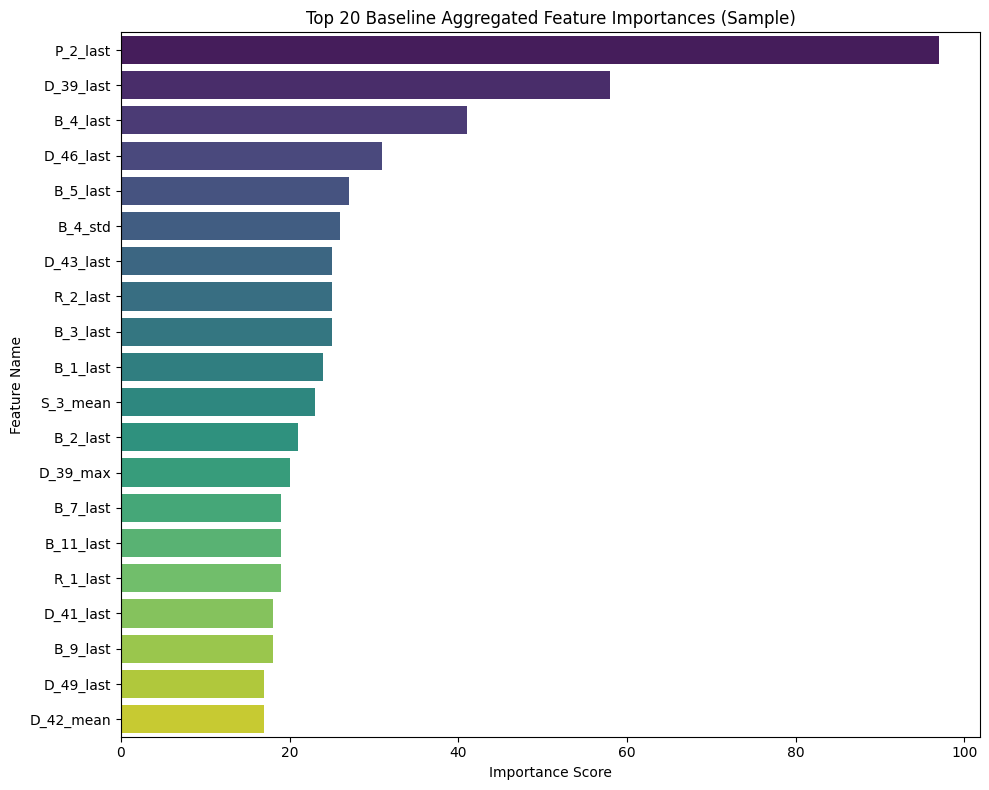


Top 10 Baseline Features:
     feature  importance
0   P_2_last          97
1  D_39_last          58
2   B_4_last          41
3  D_46_last          31
4   B_5_last          27
5    B_4_std          26
6  D_43_last          25
7   R_2_last          25
8   B_3_last          25
9   B_1_last          24


In [11]:
# Continue in your Combined_EDA.ipynb notebook

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd
import gc

# Ensure X_baseline_imputed and y_sample exist from the previous cell
if 'X_baseline_imputed' not in locals() or 'y_sample' not in locals():
    print("Error: Required DataFrames (X_baseline_imputed, y_sample) not found.")
else:
    print("\nTraining final baseline model on sample to get feature importances...")
    
    # Train one last model on ALL the sample data using the best imputation
    final_baseline_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
    #final_baseline_model.fit(X_baseline_imputed, y_sample)
    final_baseline_model.fit(X_baseline_imputed.drop(columns=['customer_ID']), y_sample)
    
    # Get and display feature importances
    print("Extracting feature importances...")
    importances = pd.DataFrame({
        'feature': X_baseline_imputed.drop(columns=['customer_ID']).columns,
        'importance': final_baseline_model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    # Plot the new top 20 most important features
    print("\nPlotting Top 20 Baseline Feature Importances...")
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importances.head(20), palette='viridis') # Added palette
    plt.title('Top 20 Baseline Aggregated Feature Importances (Sample)')
    plt.xlabel('Importance Score') # Added x-axis label
    plt.ylabel('Feature Name') # Added y-axis label
    plt.tight_layout() # Adjust layout
    plt.show()
    
    print("\nTop 10 Baseline Features:")
    print(importances.head(10))

    # Optional: Save the full importance list
    # importances.to_csv('baseline_feature_importances_sample.csv', index=False)
    # print("\nFull feature importance list saved to 'baseline_feature_importances_sample.csv'")

    # Clean up model object if needed
    del final_baseline_model
    gc.collect()

In [12]:
# --- Save Final Baseline Files (with customer_ID as a column) ---
print("\nSaving final baseline imputed features and target for the sample...")

# Define new file names
baseline_features_path = os.path.join(PARQUET_DATA_DIR, 'train_sample_features_with_id.parquet')
baseline_target_path = os.path.join(PARQUET_DATA_DIR, 'train_sample_target_with_id.parquet')

# 1. Save the features (X_baseline_imputed already contains customer_ID)
# We use index=False because customer_ID is now a column, not the index
X_baseline_imputed.to_parquet(baseline_features_path, index=False)

# 2. Save the target WITH the customer_ID
# We get these columns from the dataframe *before* we split X and y
y_sample_with_id = X_sample_agg_merged[['customer_ID', 'target']].copy()
y_sample_with_id.to_parquet(baseline_target_path, index=False)

print(f"Baseline FEATURES (with customer_ID) saved to: {baseline_features_path}")
print(f"Baseline TARGET (with customer_ID) saved to: {baseline_target_path}")

# (Optional cleanup of old files)
# os.remove(os.path.join(PARQUET_DATA_DIR, 'train_sample_baseline_features_imp0.parquet'))
# os.remove(os.path.join(PARQUET_DATA_DIR, 'train_sample_baseline_target.parquet'))


Saving final baseline imputed features and target for the sample...
Baseline FEATURES (with customer_ID) saved to: ../data_parquet/train_sample_features_with_id.parquet
Baseline TARGET (with customer_ID) saved to: ../data_parquet/train_sample_target_with_id.parquet


In [13]:
import pandas as pd
import os

# --- Define File Paths ---
PARQUET_DATA_DIR = '../data_parquet/'
features_path = os.path.join(PARQUET_DATA_DIR, 'train_sample_baseline_features_imp0.parquet')
target_path = os.path.join(PARQUET_DATA_DIR, 'train_sample_baseline_target.parquet')

# --- Load the Files ---
features_df = pd.read_parquet(features_path)
target_df = pd.read_parquet(target_path)

# --- Check Features File ---
print("--- FEATURES (X) FILE ---")
print(f"Shape: {features_df.shape}")
print("First 5 rows:")
print(features_df.head())
# Check if 'target' is in the columns
print(f"\n'target' column in features file? {'target' in features_df.columns}")

print("\n" + "="*30 + "\n")

# --- Check Target File ---
print("--- TARGET (y) FILE ---")
print(f"Shape: {target_df.shape}")
print("First 5 rows:")
print(target_df.head())
# Check if 'target' is in the columns
print(f"\n'target' column in target file? {'target' in target_df.columns}")

--- FEATURES (X) FILE ---
Shape: (45891, 915)
First 5 rows:
   P_2_mean   P_2_std   P_2_min   P_2_max  P_2_last  D_39_mean  D_39_std  \
0  0.878454  0.028911  0.797670  0.904482  0.880875   0.004181  0.002758   
1  1.005816  0.003309  1.000488  1.009762  1.009762   0.353440  0.215033   
2  0.665203  0.028379  0.628740  0.712943  0.642295   0.450042  0.208705   
3  0.986126  0.023979  0.928659  1.007868  0.988091   0.334321  0.187328   
4  0.637514  0.056002  0.570394  0.708693  0.573481   0.005379  0.003250   

   D_39_min  D_39_max  D_39_last  ...  D_63_last_CL  D_63_last_CO  \
0  0.000802  0.009704   0.009704  ...         False          True   
1  0.000811  0.560899   0.006181  ...         False          True   
2  0.005359  0.685210   0.685210  ...          True         False   
3  0.003688  0.618437   0.238952  ...          True         False   
4  0.000626  0.009622   0.000626  ...         False          True   

   D_63_last_CR  D_63_last_XL  D_63_last_XM  D_63_last_XZ  D_64_last

In [14]:
import pandas as pd
import os

# Paths to the NEW files
features_path = '../data_parquet/train_sample_features_with_id.parquet'
target_path = '../data_parquet/train_sample_target_with_id.parquet'

# Load both files
features_df = pd.read_parquet(features_path)
target_df = pd.read_parquet(target_path)

print("--- FEATURES (X) FILE ---")
print(features_df.head())
print(f"\nShape: {features_df.shape}")
print(f"'customer_ID' in features? {'customer_ID' in features_df.columns}")


print("\n" + "="*30 + "\n")

print("--- TARGET (y) FILE ---")
print(target_df.head())
print(f"\nShape: {target_df.shape}")
print(f"'customer_ID' in target? {'customer_ID' in target_df.columns}")


# --- How to combine them ---
print("\nMerging on 'customer_ID'...")
combined_df = pd.merge(features_df, target_df, on='customer_ID')

print("Combined DataFrame head:")
print(combined_df.head())
print(f"Combined shape: {combined_df.shape}") 

--- FEATURES (X) FILE ---
                                         customer_ID  P_2_mean   P_2_std  \
0  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  0.878454  0.028911   
1  0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  1.005816  0.003309   
2  0004837f0c785928a29a6f83f70f4a1c54caec483a773f...  0.665203  0.028379   
3  0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...  0.986126  0.023979   
4  00062483fb33d6129dd4ee7e5a12f751d2e7010ac0df01...  0.637514  0.056002   

    P_2_min   P_2_max  P_2_last  D_39_mean  D_39_std  D_39_min  D_39_max  ...  \
0  0.797670  0.904482  0.880875   0.004181  0.002758  0.000802  0.009704  ...   
1  1.000488  1.009762  1.009762   0.353440  0.215033  0.000811  0.560899  ...   
2  0.628740  0.712943  0.642295   0.450042  0.208705  0.005359  0.685210  ...   
3  0.928659  1.007868  0.988091   0.334321  0.187328  0.003688  0.618437  ...   
4  0.570394  0.708693  0.573481   0.005379  0.003250  0.000626  0.009622  ...   

   D_63_last_CL  D_63_last_CO 